In [1]:
import numpy as np
import os 
import cv2
import tensorflow as tf 
import keras 
import matplotlib.pyplot as plt 
import h5py
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate  
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
folder=os.listdir('/kaggle/input/brain-tumor-segmentation')
folder

['images', 'masks']

In [3]:
image_files=sorted(os.listdir('/kaggle/input/brain-tumor-segmentation/images'))
mask_files=sorted(os.listdir('/kaggle/input/brain-tumor-segmentation/masks'))

print(image_files[:10])
print(mask_files[:10])

['1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png']
['1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png']


In [4]:
def display_image_mask(image_path,mask_path):
    count=0
    for image_file,mask_file in zip(image_files,mask_files):
        if count>=6:
            break
        image_path_full=os.path.join(image_path,image_file)
        mask_path_full=os.path.join(mask_path,mask_file)

        image=cv2.imread(image_path_full)
        mask=cv2.imread(mask_path_full,cv2.IMREAD_GRAYSCALE)

        if image is None:
                raise ValueError(f"Image at path {imagepath_full} could not be loaded")
        if mask is None:
                raise ValueError(f"Mask at path {maskpath_full} could not be loaded")

        mask_3ch=cv2.merge([mask,mask,mask])
        image_rgb=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10,10))

        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Image')

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title('Mask')

        plt.subplot(1,3,3) 
        overlay = cv2.addWeighted(image_rgb, 0.7, mask_3ch, 0.3, 0)
        plt.imshow(overlay)
        plt.title("Image with overlay")

        plt.show()
        count+=1

In [5]:
image_path='/kaggle/input/brain-tumor-segmentation/images'
mask_path='/kaggle/input/brain-tumor-segmentation/masks'

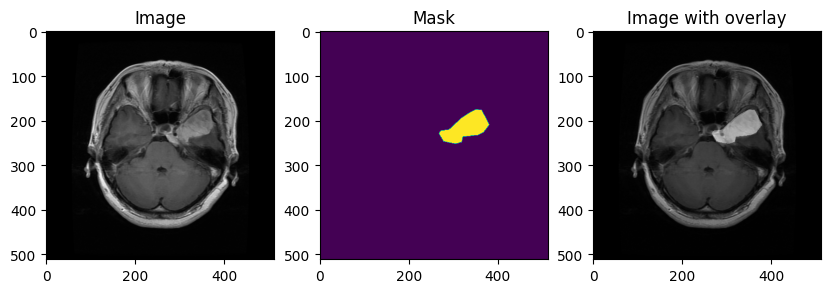

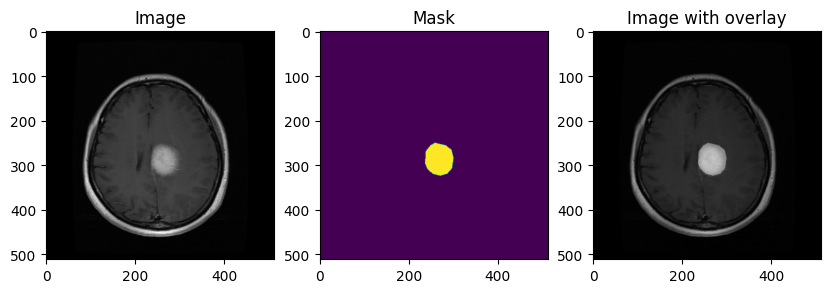

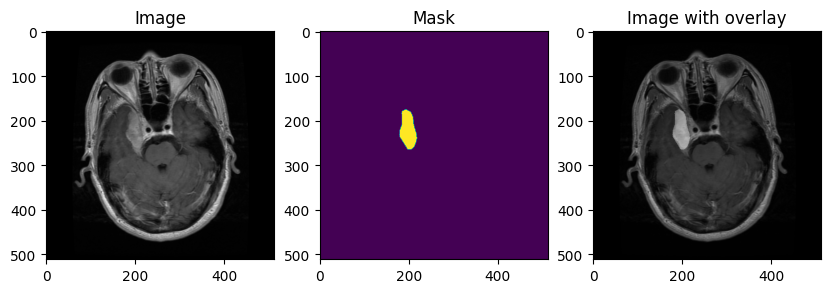

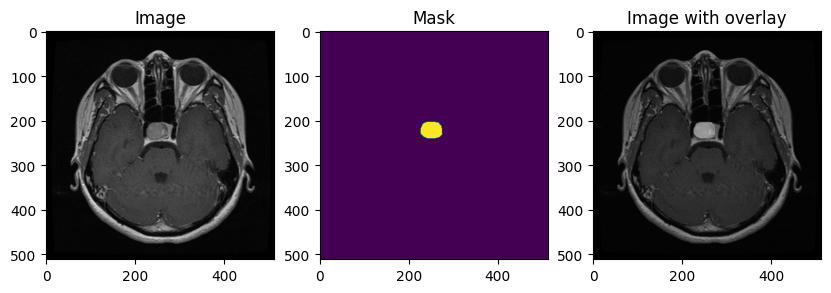

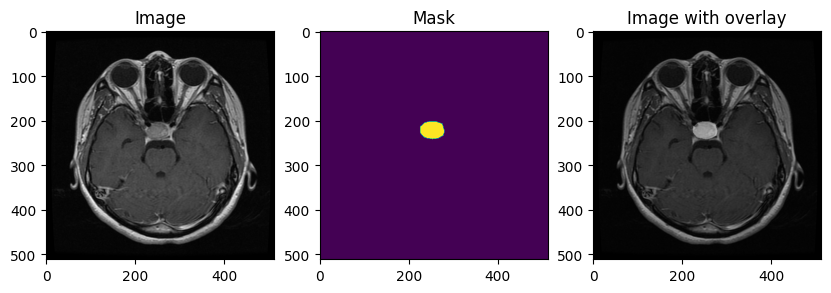

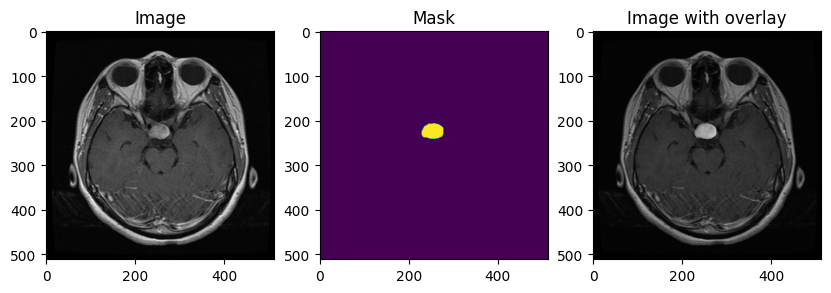

In [6]:
display_image_mask(image_path,mask_path)

In [7]:
images_size=[]
masks_size=[]

for image_file, mask_file in tqdm(zip(image_files, mask_files)):


    imagepath_full = os.path.join(image_path, image_file)
    maskpath_full = os.path.join(mask_path, mask_file)

    image = cv2.imread(imagepath_full)
    mask = cv2.imread(maskpath_full)

    images_size.append(image.shape)
    masks_size.append(mask.shape)

3064it [01:12, 42.36it/s]


In [8]:
print(list(set(images_size)))
print(list(set(masks_size)))

[(512, 512, 3), (256, 256, 3)]
[(512, 512, 3), (256, 256, 3)]


In [9]:
SIZE=224
CHANNEL=1

In [10]:
def preprocessing_images_masks():
    images=[]
    masks=[]

    for image_file, mask_file in tqdm(zip(image_files,mask_files)):
        imagepathfull=os.path.join(image_path,image_file)
        maskpathfull=os.path.join(mask_path,mask_file)

        image = cv2.imread(imagepathfull,cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image,(SIZE,SIZE))
        image=cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        image = image/255.0
        images.append(image)

        mask = cv2.imread(maskpathfull,cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask,(SIZE,SIZE))
        mask = mask/255.0
        masks.append(mask)

    return np.array(images), np.expand_dims(np.array(masks), axis=-1)

In [11]:
X,y=preprocessing_images_masks()

3064it [00:22, 138.95it/s]


In [12]:
print('Shape of X:',X.shape)
print('Shape of y:',y.shape)

Shape of X: (3064, 224, 224, 3)
Shape of y: (3064, 224, 224, 1)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
print('The shape of X_train',X_train.shape)
print('The shape of y_train',y_train.shape)
print('The shape of X_test',X_test.shape)
print('The shape of y_test',y_test.shape)

The shape of X_train (2451, 224, 224, 3)
The shape of y_train (2451, 224, 224, 1)
The shape of X_test (613, 224, 224, 3)
The shape of y_test (613, 224, 224, 1)


In [15]:
smooth = 1e-15
@keras.saving.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [16]:
train_datagen=ImageDataGenerator(brightness_range=(0.9,1.1),
                                 zoom_range=[.9,1.1],
                                 fill_mode='nearest')
val_datagen=ImageDataGenerator()

In [17]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape):
    """ Input """
    inputs = Input(shape=input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = resnet50.get_layer("input_layer").output           ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model

input_shape = (224,224, 3)
model = build_resnet50_unet(input_shape)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "ResNet50_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 20,676,545 (78.87 MB)

 Trainable params: 20,642,113 (78.74 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [18]:
model_checkpoint  = ModelCheckpoint('best_model_checkpoint.keras', save_best_only=True,
                                    monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')

callback_list = [early_stopping, reduceLR, model_checkpoint]

In [19]:
batch_size = 16

train_generator = train_datagen.flow( X_train, y_train, batch_size=batch_size, shuffle=True)

val_generator = val_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=dice_loss,
              metrics=[dice_coef, 'accuracy'])

In [21]:
history = model.fit(
    X_train, y_train, batch_size=32, epochs=100,validation_data=(X_test, y_test),verbose=1,callbacks=callback_list)

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7074 - dice_coef: 0.0409 - loss: 0.9591
Epoch 1: val_loss improved from inf to 0.96886, saving model to best_model_checkpoint.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.7069 - dice_coef: 0.0411 - loss: 0.9589 - val_accuracy: 0.5689 - val_dice_coef: 0.0320 - val_loss: 0.9689 - learning_rate: 1.0000e-05
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7767 - dice_coef: 0.0938 - loss: 0.9062
Epoch 2: val_loss did not improve from 0.96886
77/77 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.7777 - dice_coef: 0.0941 - loss: 0.9059 - val_accuracy: 0.3192 - val_dice_coef: 0.0319 - val_loss: 0.9690 - learning_rate: 1.0000e-05
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9561 - dice_coef: 0.1753 - loss: 0.8247
Epoch 3: val_loss did not improve from 0.96886
77/77 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9561 - dice_coef: 0.1755 - loss: 0.8245 - val_accuracy: 0.9422 - val_dice_

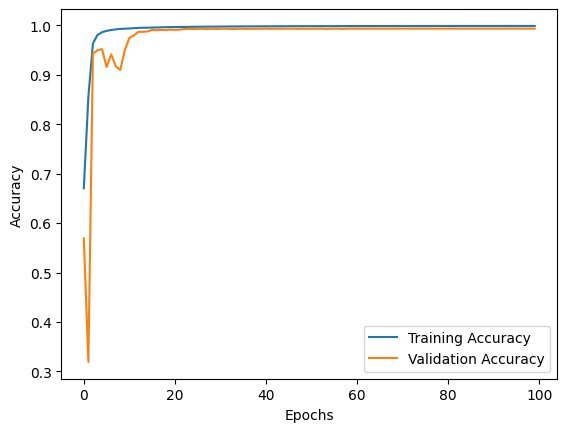

In [22]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


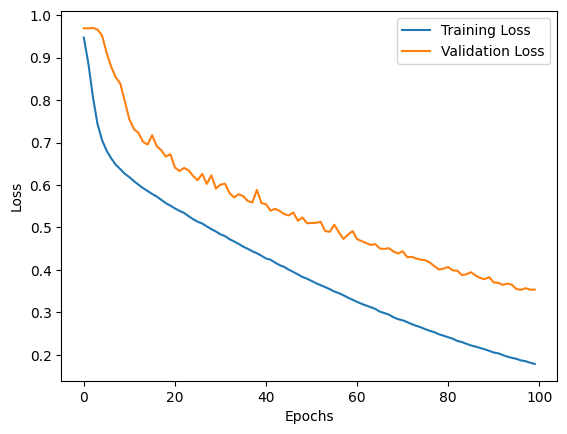

In [23]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
loss,dice_coef,accuracy=model.evaluate(X_test,y_test)
print(f'Loss is {loss}')
print(f'Accuracy is {accuracy}')
print(f'Dice_Coef is {dice_coef}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 365ms/step - accuracy: 0.9934 - dice_coef: 0.6488 - loss: 0.3516
Loss is 0.35368579626083374
Accuracy is 0.9931914210319519
Dice_Coef is 0.6500974893569946


In [25]:
model.save("unet_resnet50_backbone.keras")

In [26]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(np.uint8)

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 506ms/step


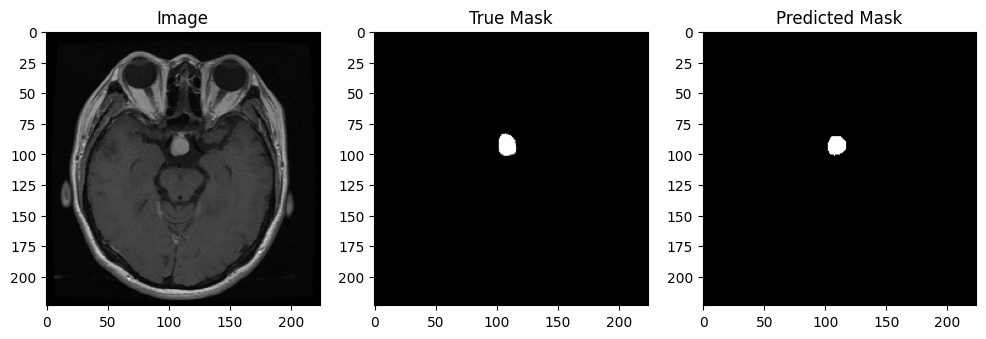

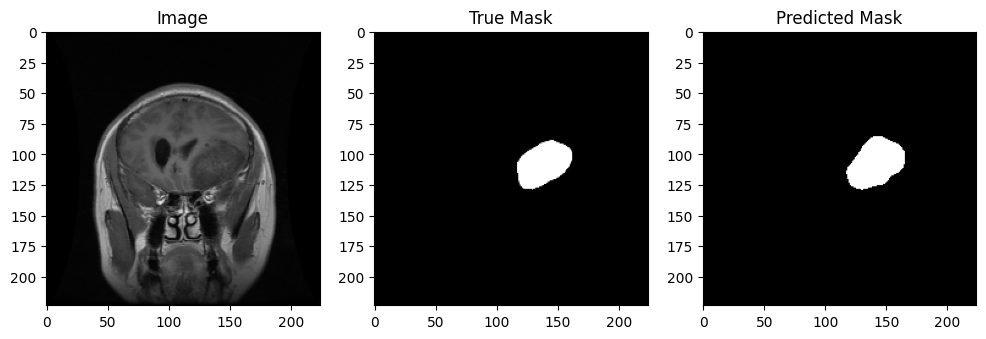

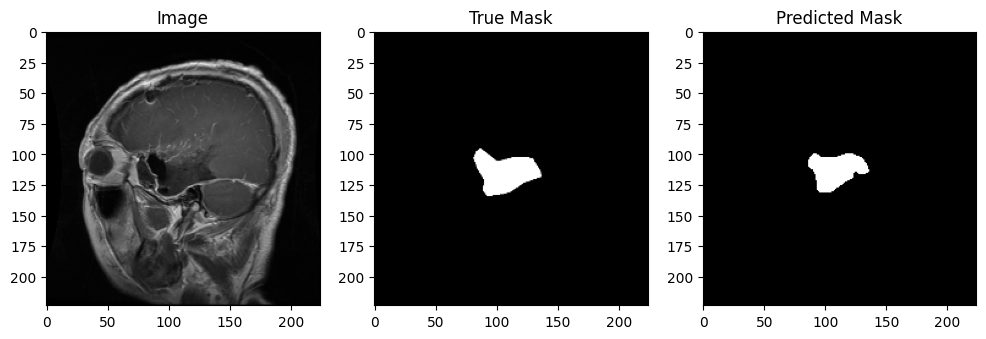

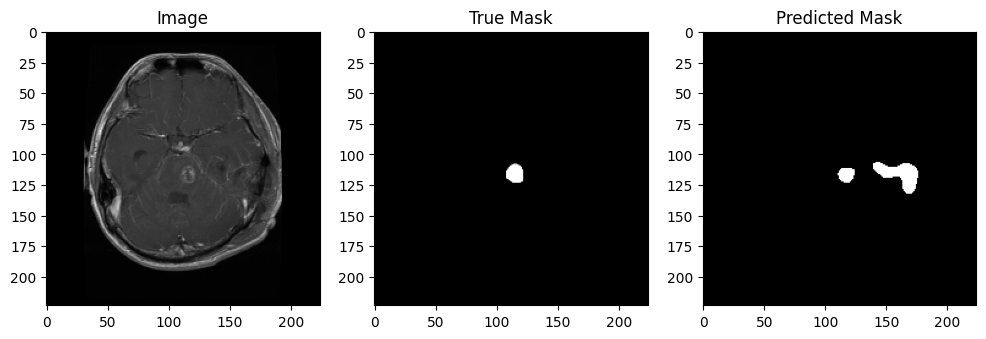

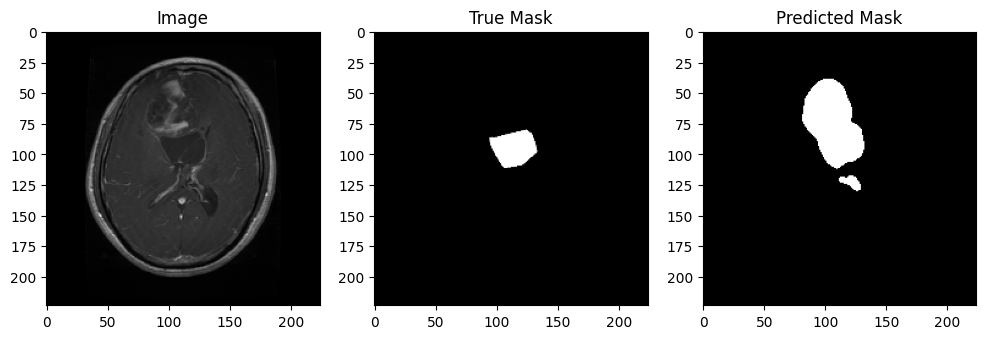

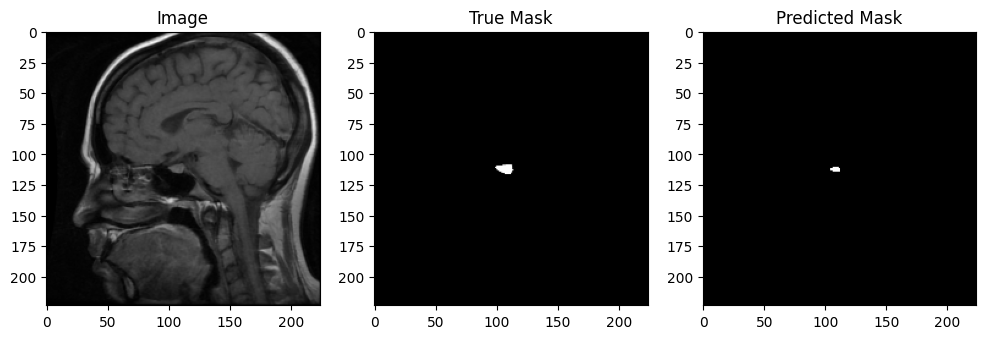

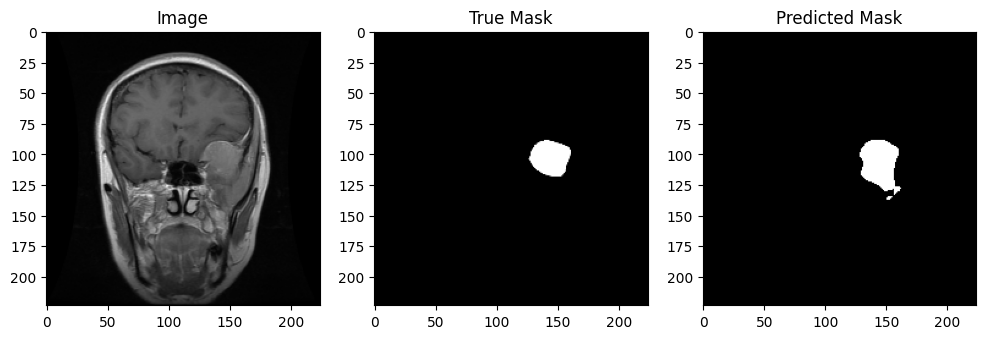

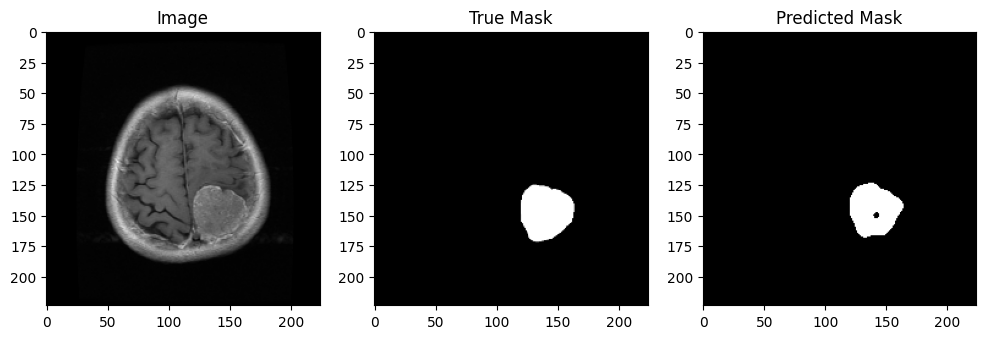

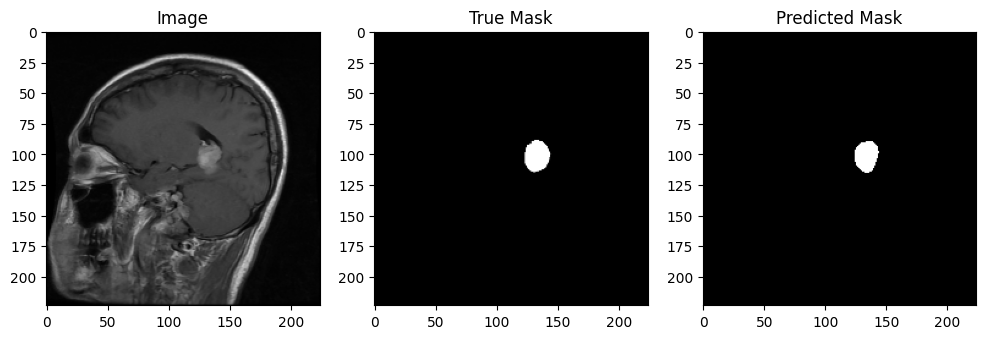

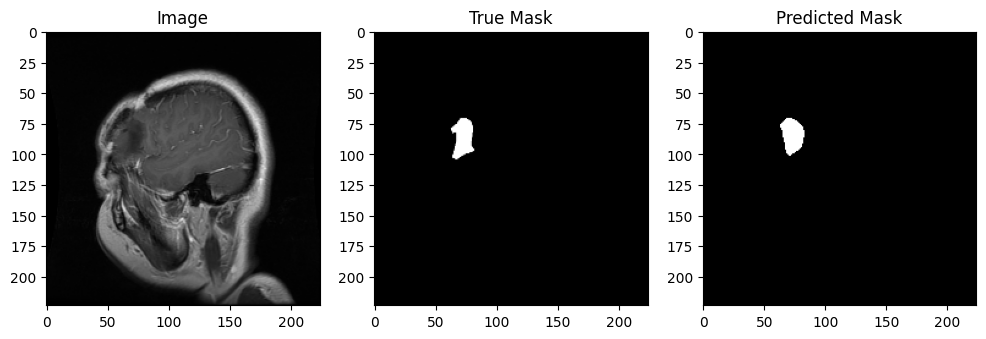

In [27]:
for i in range(10):
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(X_test[i],cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(y_pred[i].squeeze(), cmap='gray')
    
    plt.show()